In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
%matplotlib inline


np.random.seed(1)
N = 200
K = 3
M = 2
T3 = np.zeros((N,3))
T2 = np.zeros((N,2))
X = np.zeros((N,K))
X_range0 = [-3, 3]
X_range1 = [-3, 3]
print(np.shape(T3))
# print(T3)
mu = np.array([[-0.5, -0.5], [0.5, 1.0], [1, -0.5]])
sig = np.array([[0.7, 0.7], [0.8, 0.3], [0.3, 0.8]])
pi = np.array([0.4, 0.8, 1])

for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk < pi[k]:
            T3[n, k] = 1
            break
    for k in range(2):
#         print(sig[T3[n, : ]== 1, k])
#         T3[n, : ]== 1　は　0,1,2のどれかを返す
        X[n, k] = np.random.randn() * sig[T3[n, : ] == 1, k] + mu[T3[n, :] == 1, k]
        
X[:, M] = 1
# T2[:, 0] = T3[:, 0]
# T2[:,1] = T3[:, 1]
# T2[:,1] = T2[:, 1] + T3[:, 2]

(200, 3)


In [3]:
TestRatio = 0.5
X_n_training = int(N * TestRatio)
X_train = X[:X_n_training, :]
X_test = X[X_n_training:, :]
T_train = T3[:X_n_training, :]
T_test = T3[X_n_training:, :]

np.savez("class_data.npz", X_train=X_train, T_train=T_train, X_test=X_test, T_test=T_test, X_range0=X_range0, X_range1=X_range1)



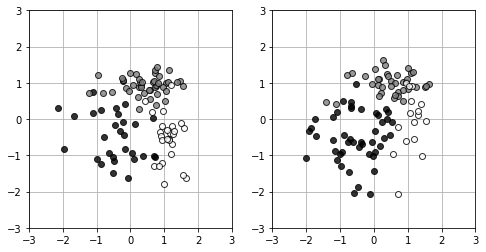

In [60]:

def show_data(x, t):
    wk, n = t.shape
    c = [[0, 0, 0], [0.5, 0.5, 0.5],[1, 1, 1]]
    for i in range(n):
        plt.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1], linestyle = "none", marker = "o", markeredgecolor = "black", color = c[i], alpha = 0.8)
    plt.grid()
    
plt.figure(1, figsize=(8, 4))
plt.subplot(1, 2, 1)
show_data(X_train, T_train)
plt.xlim(X_range0)
plt.ylim(X_range1)


plt.subplot(1, 2, 2)
show_data(X_test, T_test)
plt.xlim(X_range0)
plt.ylim(X_range1)

plt.show()

In [4]:
def sigmoid(x):
    y = 1 / (1 + np.exp(-x))

    return y

def fnn(wv, M, K, x):
    N, D = x.shape
    w = wv[:M * D]
    w = w.reshape(M, D)
    
    v = wv[M * D:]
    v = v.reshape(K, (M + 1))
    b = np.zeros((N, M +1))
    z = np.zeros((N, M +1))
    z[:, M] = 1
    a = np.zeros((N, K))
    y = np.zeros((N, K))
    
    for n in range(N):
        for m in range(M):
            b[n, m] = np.dot(w[m, :], x[n, :])
            z[n, m] = sigmoid(b[n,m])
        wkz = 0
#         z[n, M] = 1
        
        for k in range(K):
            a[n, k] = np.dot(v[k, :], z[n, :])
            wkz = wkz + np.exp(a[n, k])
        for k in range(K):
            y[n,k] = np.exp(a[n,k]) / wkz
    return y, a, z, b

def ce_fnn(wv, M, K, x, t):
    N, D = x.shape
    y, a, z, b = fnn(wv, M, K, x)
    ce = -np.dot(np.log(y.reshape(-1)), t.reshape(-1)) / N
    return ce

def dce_fnn_num(wv, M, K, x, t):
    epsilon = 0.001
    # 元の配列と同じ形状の配列を生成する中身はゼロ
    dwv = np.zeros_like(wv)
    for iwv in range(len(wv)):
        # 値渡し？
        # ただの代入だと参照渡しといって、元の配列にも影響が出てしまう
        wv_modified = wv.copy()
        wv_modified[iwv] = wv[iwv] - epsilon
        mse1 = ce_fnn(wv_modified, M, K, x, t)
        wv_modified[iwv] = wv[iwv] + epsilon
        mse2 = ce_fnn(wv_modified, M, K, x, t)
        dwv[iwv] = (mse2 - mse1) / (2 * epsilon)
    return dwv

def fit_fnn_num(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha):
    wvt = wv_init
    err_train = np.zeros(n)
    err_test = np.zeros(n)
    wv_hist = np.zeros((n, len(wv_init)))

    for i in range(n):
        wvt  = wvt - alpha * dce_fnn_num(wvt, M, K, x_train, t_train)
        err_train[i] = ce_fnn(wvt, M, K, x_train, t_train)
        err_test[i] = ce_fnn(wvt, M, K, x_test, t_test)
        wv_hist[i, :] = wvt
    return wvt, wv_hist, err_train, err_test

def dce_fnn(wv, M, K, x, t):
    N, D = x.shape

    w = wv[:M * D]
    w = w.reshape(M, D)
    
    v = wv[M * D:]
    v = v.reshape(K, (M + 1))
    
    y, a, z, b = fnn(wv, M, K, x)
    
    dwv = np.zeros_like(wv)
    dw = np.zeros((M, D))
    dv = np.zeros((K, M + 1))
    delta1 = np.zeros(M)
    delta2 = np.zeros(K)
    
    for n in range(N):
        
        for k in range(K):
            delta2[k] = (y[n, k] - t[n, k])
            
        for j in range(M):
            delta1[j] = z[n, j] * (1 - z[n, j]) * np.dot(v[:, j], delta2)
            
        for k in range(K):
            dv[k, :] = dv[k, :] + delta2[k] * z[n, :] / N
            
        for j in range(M):
            dw[j, :] = dw[j, :] + delta1[j] * x[n, :] / N
            
    dwv = np.c_[dw.reshape((1, M * D)), dv.reshape(1, K * (M + 1))]
    dwv = dwv.reshape(-1)
    
    return dwv

def fit_fnn(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha):
    wvt = wv_init
    err_train = np.zeros(n)
    err_test = np.zeros(n)
    wv_hist = np.zeros((n, len(wv_init)))

    for i in range(n):
        wvt  = wvt - alpha * dce_fnn(wvt, M, K, x_train, t_train)
        err_train[i] = ce_fnn(wvt, M, K, x_train, t_train)
        err_test[i] = ce_fnn(wvt, M, K, x_test, t_test)
        wv_hist[i, :] = wvt
    return wvt, wv_hist, err_train, err_test

# def show_fnn(wv, M, K):

#     xn =60
#     x0 = np.linspace(X_range0[0], X_range0[1], xn)
#     x1 = np.linspace(X_range1[0], X_range1[1], xn)
#     xx0, xx1 = np.meshgrid(x0, x1)
#     x = np.c_[np.reshape(xx0, xn * xn, 1), np.reshape(xx1, xn * xn, 1)]
#     print(np.shape(x))
#     y, a, z, b = fnn(wv, M, K, x)
#     plt.figure(1, figsize=(4,4))
#     for ic in range(K):
#         f = y[:, ic]
#         f = f.reshape(xn,xn)
#         f = f.T
#         cont = plt.contour(xx0, xx1, f, levels = [0.8, 0.9], colors = ["blue", "black"])
#         cont.clabel(fmt = "%1.1f", fontsize = 9)
#     plt.xlim(X_range0)
#     plt.ylim(X_range1)
    
def show_wv(wv, M):
    N = wv.shape[0]
    plt.bar(range(1, M * 3 + 1), wv[:M * 3], align = "center", color = "black")
    plt.bar(range(M * 3 + 1, N + 1), wv[M * 3:], align = "center", color = "blue")
    plt.xticks(range(1, N + 1))
    plt.xlim(0, N + 1)

[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


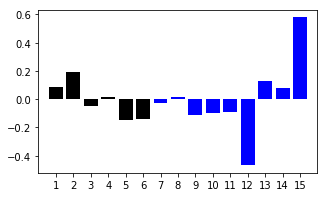

In [5]:
np.random.seed(1)
WV_init = np.random.normal(0, 1, M * 3 + K * (M + 1))
dwv = dce_fnn_num(WV_init, M ,K, X_train[:2, :], T_train[:2, :])
print(dwv)
plt.figure(1, figsize=(5,3))
show_wv(dwv, M)
plt.show()

In [25]:
WV = np.ones(15)
M = 2
K = 3
fnn(WV,M, K, X_train[:2, :])

(array([[0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.33333333, 0.33333333]]),
 array([[2.6971835 , 2.6971835 , 2.6971835 ],
        [1.49172649, 1.49172649, 1.49172649]]),
 array([[0.84859175, 0.84859175, 1.        ],
        [0.24586324, 0.24586324, 1.        ]]),
 array([[ 1.72359839,  1.72359839,  0.        ],
        [-1.12079826, -1.12079826,  0.        ]]))

In [9]:
np.shape(T_train)

(100, 3)

9.621285915374756
0.2233510874464127
0.29465517042607353


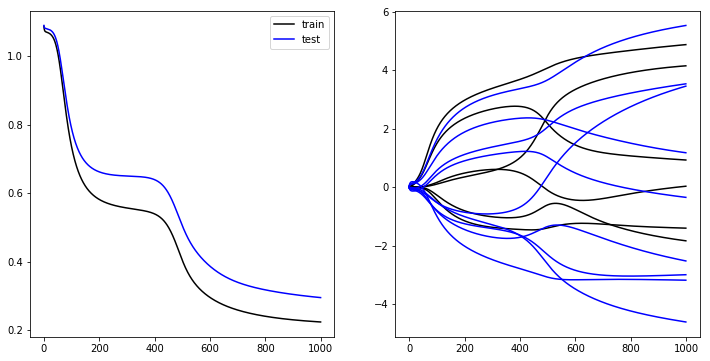

In [11]:
import time
np.random.seed(1)
starttime = time.time()
WV_init = np.random.normal(0, 0.01, M * 3 + K * (M + 1))
# Xavier の初期値 　= 1 / √前層のノード数
W_init_X = np.random.randn(M * 3) / np.sqrt(np.shape(X_train)[1])
V_init_X = np.random.randn(K * (M + 1)) / np.sqrt(M)
WV_init_X = np.r_[W_init_X, V_init_X]

N_step = 1000
alpha = 0.5
WV, WV_hist, Err_train, Err_test = fit_fnn(WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)
ca_time = time.time() - starttime
print(ca_time)
print(min(Err_train))
print(min(Err_test))

plt.figure(1, figsize=(12, 6))

plt.subplot(1,2,1)
plt.plot(Err_train, "black", label="train")
plt.plot(Err_test, "blue",label="test")
plt.legend()

plt.subplot(1,2,2)
plt.plot(WV_hist[:, :M*3], "black")
plt.plot(WV_hist[:, M*3:], "blue")
plt.show()